In [1]:
# test
import torch
import numpy as np
from spectralnet import SpectralNet

features = [torch.randn(100) for i in range(50)]
len(features)

50

In [12]:
features_tensor = torch.stack(features, dim=0)
features_tensor.shape, type(features_tensor)

(torch.Size([50, 100]), torch.Tensor)

In [13]:
spectralnet = SpectralNet(n_clusters=4)
spectralnet.fit(features_tensor)
cluster_assignments = spectralnet.predict(features_tensor)

Training SpectralNet:


Train Loss: 67.0490799, Valid Loss: 1.0531747, LR: 0.000100: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


In [14]:
cluster_assignments

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [21]:
_indices1, _counts1 = np.unique(cluster_assignments, return_counts=True)
print(f'Cluster indices: {_indices1.tolist()}')
print(f'Cluster counts: {_counts1.tolist()}')

Cluster indices: [0, 1, 2, 3]
Cluster counts: [47, 1, 1, 1]


In [24]:
# kemans
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=4, batch_size=10, max_iter=5000, random_state=1)
clusters = kmeans.fit_predict(features_tensor)

/home/guests/oleksandra_tmenova/test/project/.venv-p311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [25]:
_indices, _counts = np.unique(clusters, return_counts=True)
print(f'Cluster indices: {_indices.tolist()}')
print(f'Cluster counts: {_counts.tolist()}')

Cluster indices: [0, 1, 2]
Cluster counts: [1, 1, 48]


## TEST ON BBOX FEATURES

In [1]:
bbox_path = "/home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/outputs/liver_mixed_val_mini/exp_clustering_sweep/2023-11-07/12-55-48/seg5_clust5_norm-imagenet_prepr-False_dino1_clusterkmeans/multi_region_bboxes/laplacian/bbox_features.pth"

In [3]:
bbox_list = torch.load(bbox_path)
total_num_boxes = sum(len(d['bboxes']) for d in bbox_list)
print(f'Loaded bounding box list. There are {total_num_boxes} total bounding boxes with features.')


Loaded bounding box list. There are 40 total bounding boxes with features.


In [15]:
# Loop over boxes and stack features with PyTorch, because Numpy is too slow
print(f'Stacking and normalizing features')
all_features = torch.cat([bbox_dict['features'] for bbox_dict in bbox_list], dim=0)  # (numBbox, D)


Stacking and normalizing features


In [27]:
all_features_norm = all_features / torch.norm(all_features, dim=-1, keepdim=True)  # (numBbox, D)f
type(all_features_norm), all_features_norm.shape

(torch.Tensor, torch.Size([40, 384]))

In [11]:
all_features.shape

torch.Size([40, 384])

In [12]:
type(all_features)

torch.Tensor

In [29]:
# tensors need to be detached
all_features_norm_numpy = all_features_norm.detach().numpy()
type(all_features_norm_numpy)

numpy.ndarray

In [31]:
print(f'Computing clusters using a SpectralNet model with {6} clusters')
# ref: https://github.com/shaham-lab/SpectralNet
spectralnet = SpectralNet(n_clusters=6)
spectralnet.fit(all_features_norm)
clusters = spectralnet.predict(all_features_norm)

Computing clusters using a SpectralNet model with 6 clusters
Training SpectralNet:


  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 70.6985779, Valid Loss: 5.4345760, LR: 0.001000: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s] 


In [32]:
_indices, _counts = np.unique(clusters, return_counts=True)
print(f'Cluster indices: {_indices.tolist()}')
print(f'Cluster counts: {_counts.tolist()}')

Cluster indices: [0, 1, 2, 3, 4, 5]
Cluster counts: [3, 17, 3, 15, 1, 1]


In [30]:
# kemans
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=6, batch_size=10, max_iter=5000, random_state=1)
clusters2 = kmeans.fit_predict(all_features_norm_numpy)
_indices2, _counts2 = np.unique(clusters2, return_counts=True)
print(f'Cluster indices: {_indices2.tolist()}')
print(f'Cluster counts: {_counts2.tolist()}')

/home/guests/oleksandra_tmenova/test/project/.venv-p311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Cluster indices: [0, 1, 2, 3, 4, 5]
Cluster counts: [7, 10, 2, 7, 5, 9]


In [33]:
spectralnet = SpectralNet(n_clusters=6,
                        should_use_siamese=True)
spectralnet.fit(all_features_norm)
clusters3 = spectralnet.predict(all_features_norm)

Training Siamese Network:


  0%|          | 0/30 [00:00<?, ?it/s]

Train Loss: 0.0452721, Valid Loss: 0.0934938, LR: 0.000100: 100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Training SpectralNet:


Train Loss: 84.5544662, Valid Loss: 2.0103896, LR: 0.001000: 100%|██████████| 30/30 [00:19<00:00,  1.53it/s] 


In [34]:
_indices3, _counts3 = np.unique(clusters3, return_counts=True)
print(f'Cluster indices: {_indices3.tolist()}')
print(f'Cluster counts: {_counts3.tolist()}')

Cluster indices: [0, 1, 2, 3, 4, 5]
Cluster counts: [7, 15, 15, 1, 1, 1]


In [35]:
spectralnet = SpectralNet(n_clusters=6,
                        should_use_siamese=True,
                        should_use_ae = True)
spectralnet.fit(all_features_norm)
clusters4 = spectralnet.predict(all_features_norm)
_indices4, _counts4 = np.unique(clusters4, return_counts=True)
print(f'Cluster indices: {_indices4.tolist()}')
print(f'Cluster counts: {_counts4.tolist()}')

Training Autoencoder:


  0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0005408, Valid Loss: 0.0005311, LR: 0.001000: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Embedding data ...
Training Siamese Network:


Train Loss: 0.0335772, Valid Loss: 0.0049722, LR: 0.001000: 100%|██████████| 30/30 [00:27<00:00,  1.10it/s]


Training SpectralNet:


Train Loss: 91.1314926, Valid Loss: 30.0833397, LR: 0.000100: 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]  


Cluster indices: [0, 1, 2, 3, 4, 5]
Cluster counts: [10, 11, 14, 2, 2, 1]


In [2]:
clusters4

NameError: name 'clusters4' is not defined

## DO THE SAME FOR PER IMAGE CLUSTERING?


In [38]:
feature_path = "/home/guests/oleksandra_tmenova/test/project/thesis-codebase/deep-spectral-segmentation/outputs/liver_mixed_val_mini/exp_clustering_sweep/2023-11-07/13-13-13/seg8_clust6_norm-imagenet_prepr-False_dino1_clusterkmeans/features/dino_vits8/Patient-12-david-01_7.pth"

In [39]:
data_dict = torch.load(feature_path, map_location='cpu')

In [40]:
feats = data_dict['k'].squeeze()
feats_numpy = feats.numpy()
feats.shape, feats_numpy.shape

(torch.Size([10455, 384]), (10455, 384))

In [42]:
n_clusters = 6

In [43]:
# kmeans baseline
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
clusters = kmeans.fit_predict(feats_numpy)

/home/guests/oleksandra_tmenova/test/project/.venv-p311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [59]:
# # spectral_net
# spectralnet = SpectralNet(n_clusters=n_clusters,
#                         should_use_siamese=True,
#                         should_use_ae = True)
# spectralnet.fit(feats)
# clusters_sn = spectralnet.predict(feats)

In [60]:
# spectral_net
spectralnet = SpectralNet(n_clusters=n_clusters)
spectralnet.fit(feats)
clusters_sn = spectralnet.predict(feats)

Training SpectralNet:


Train Loss: 6.2421930, Valid Loss: 25.2269623, LR: 0.001000: 100%|██████████| 30/30 [13:53<00:00, 27.77s/it]


In [47]:
def get_image_sizes(data_dict: dict, downsample_factor = None):
    P = data_dict['patch_size'] if downsample_factor is None else downsample_factor
    B, C, H, W = data_dict['shape']
    assert B == 1, 'assumption violated :('
    H_patch, W_patch = H // P, W // P
    H_pad, W_pad = H_patch * P, W_patch * P
    return (B, C, H, W, P, H_patch, W_patch, H_pad, W_pad)

In [49]:
def get_border_fraction(segmap: np.array):
    num_border_pixels = 2 * (segmap.shape[0] + segmap.shape[1])
    counts_map = {idx: 0 for idx in np.unique(segmap)}
    np.zeros(len(np.unique(segmap)))
    for border in [segmap[:, 0], segmap[:, -1], segmap[0, :], segmap[-1, :]]:
        unique, counts = np.unique(border, return_counts=True)
        for idx, count in zip(unique.tolist(), counts.tolist()):
            counts_map[idx] += count
    # normlized_counts_map = {idx: count / num_border_pixels for idx, count in counts_map.items()}
    indices = np.array(list(counts_map.keys()))
    normlized_counts = np.array(list(counts_map.values())) / num_border_pixels
    return indices, normlized_counts

In [48]:
# get segmentation map
B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = get_image_sizes(data_dict)


In [51]:
# Reshape
infer_bg_index = True
if clusters.size == H_patch * W_patch:  # TODO: better solution might be to pass in patch index
    segmap = clusters.reshape(H_patch, W_patch)
elif clusters.size == H_patch * W_patch * 4:
    segmap = clusters.reshape(H_patch * 2, W_patch * 2)
else:
    raise ValueError()

# TODO: Improve this step in the pipeline.
# Background detection: we assume that the segment with the most border pixels is the 
# background region. We will always make this region equal 0. 
if infer_bg_index:
    indices, normlized_counts = get_border_fraction(segmap)
    bg_index = indices[np.argmax(normlized_counts)].item()
    bg_region = (segmap == bg_index)
    zero_region = (segmap == 0)
    segmap[bg_region] = 0
    segmap[zero_region] = bg_index

In [57]:
from PIL import Image
# Image.fromarray(segmap*255).convert('L').show()
import matplotlib.pyplot as plt

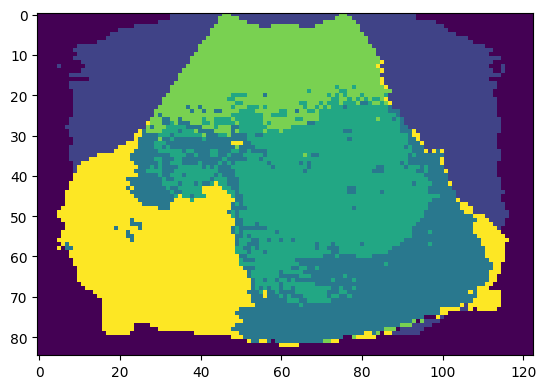

In [58]:
plt.imshow(segmap)

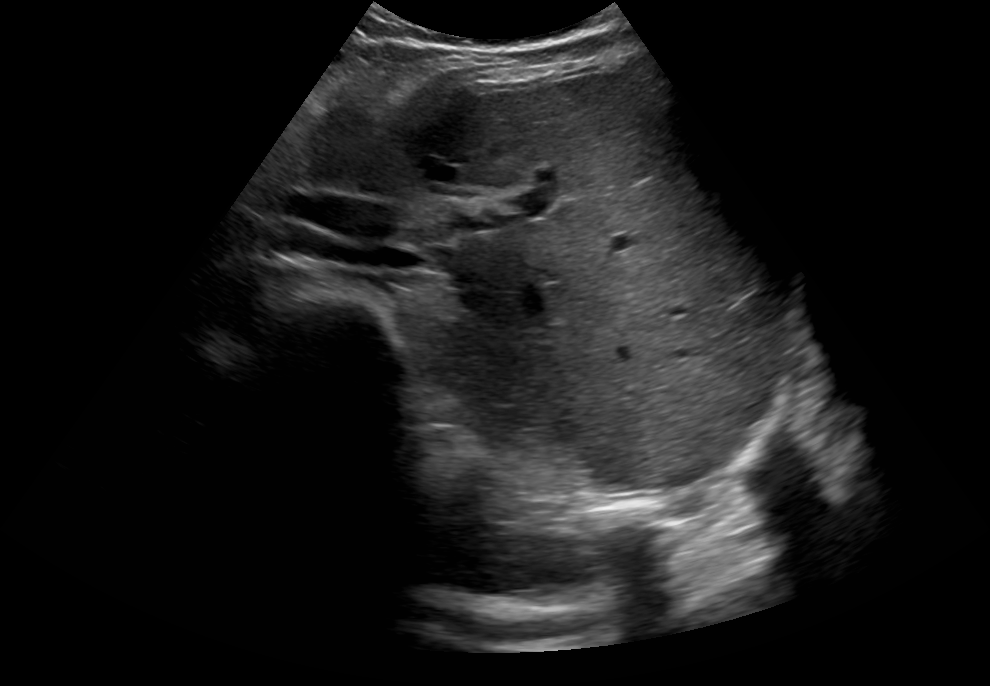

In [56]:
image_path = "/home/guests/oleksandra_tmenova/test/project/thesis-codebase/data/LIVER_MIXED/val_mini/images/Patient-12-david-01_7.png"
image = Image.open(image_path)
image.show()

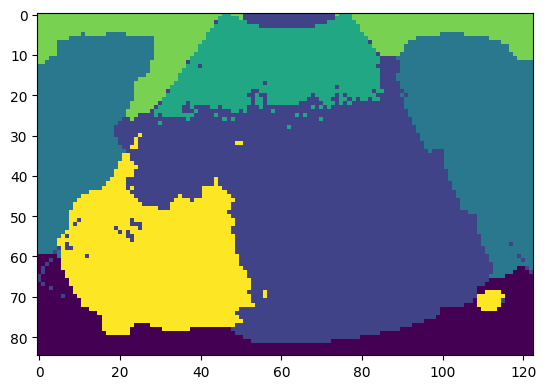

In [61]:
# Reshape
infer_bg_index = True
if clusters_sn.size == H_patch * W_patch:  # TODO: better solution might be to pass in patch index
    segmap = clusters_sn.reshape(H_patch, W_patch)
elif clusters.size == H_patch * W_patch * 4:
    segmap = clusters_sn.reshape(H_patch * 2, W_patch * 2)
else:
    raise ValueError()

# TODO: Improve this step in the pipeline.
# Background detection: we assume that the segment with the most border pixels is the 
# background region. We will always make this region equal 0. 
if infer_bg_index:
    indices, normlized_counts = get_border_fraction(segmap)
    bg_index = indices[np.argmax(normlized_counts)].item()
    bg_region = (segmap == bg_index)
    zero_region = (segmap == 0)
    segmap[bg_region] = 0
    segmap[zero_region] = bg_index

plt.imshow(segmap)

## a quick test

In [ ]:
feats = [torch.randn(100) for i in range(20) ]
feats = torch.stack(feats, dim=0)
feats = feats.to(device)